In [1]:
# 適宜自分のApplicationPATHまで変更
APP_PATH = '/root'
# APP_PATH = '.'


# 標準モジュール(install不要)
import os
import random

# import time
# import copy
# from collections import defaultdict
import torch
# import shutil
# import pandas as pd
from skimage import io, transform # scikit-image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils # 現時点では使ってない
from torch import nn
import albumentations as alb
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
# import zipfile


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

TRAIN_PATH = APP_PATH + '/data/img'
CHECKPOINT_PATH = APP_PATH + '/data/model'
CHECKPOINT_PATH_UNet = CHECKPOINT_PATH + '/UNet'

# os.chdir(APP_PATH)

In [2]:
# ファイルの実行(ノートブック側でランタイムの再接続 or reloadをする)
# importで実行するときはファイルのパスを通す必要がある
# sys.path.append(APP_PATH + '/bin')

# setupなどのOSに関するコマンド実行はその定義ファイルをコマンドで実行
# 関数などのモジュールはimportで扱えるようにして実行
# !python bin/setup.py

# はじめから256にresizeされている
IMG_HEIGHT = 256
IMG_WIDTH = 256

NUM_EPOCHS = 100

In [3]:
#画像データ拡張の関数
def get_train_transform():
    
   return alb.Compose(
       [
        #リサイズ(元画像ですでにしているが)
        alb.Resize(IMG_HEIGHT, IMG_WIDTH),
        #正規化(こちらの細かい値はalbumentations.augmentations.transforms.Normalizeのデフォルトの値を適用)
        alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #水平フリップ（pはフリップする確率）
        alb.HorizontalFlip(p=0.25),
        #垂直フリップ
        alb.VerticalFlip(p=0.25),
        ToTensorV2(),
        ])

#Datasetクラスの定義
class LoadDataSet(Dataset):
        def __init__(self, path, transform=None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_train_transform()
        
        def __len__(self):
            return len(self.folders)

        def __getitem__(self, idx):
            image_folder = os.path.join(self.path, self.folders[idx], 'images/')
            mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
            image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
            
            # debug
            # print(f'image_folder: {image_folder}')
            # print(f'mask_folder: {mask_folder}')
            # print(f'image_path: {image_path}')
            # print(f'mask_path: {mask_path}')
            
            #画像データの取得
            # 3次元の処理を2次元に変更するのがいろいろめんどくさいから3次元の型で扱うことにする
            ## exec img
            # img = io.imread(image_path)[:,:,:3].astype('float32')
            img = io.imread(image_path)
            # TODO: 正答率がでたら比較としてfloat32でも試してみる
            # print(f'2d img.shape: {img.shape}') # 白黒なのでチャネル数が省略されて2次元データになっている
            img = self.conv_2D_to_3Darray(img)
            # print(f'3d img.shape: {img.shape}')


            ## exec mask
            # img = transform.resize(img,(256,256))
            ## mask = io.imread(mask_path)
            # maskの量が2つ以上になったらここの関数を実行してすべてを得る
            # mask = self.get_mask(mask_folder, 256, 256).astype('float32')
            mask = self.get_mask(mask_folder, IMG_HEIGHT, IMG_WIDTH) # nint8でOK?
            # print(f'calced mask.shape: {mask.shape}')

            # 前処理をするためにひとつにまとめる
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            return (img,mask)
        
        def conv_2D_to_3Darray(self, arr):
            # print(f'exec conv_2D_to_3Darray')
            image = Image.fromarray(arr)
            image = image.convert("RGB")
            # 変換するならここでfloat32にする
            arr = np.asarray(image, np.uint8)
            # print(f'to3d arr shape: {arr.shape}')
            return arr

        def conv_3D_to_2Darray(self, arr):
            # print(f'exec conv_3D_to_2Darray')
            image = Image.fromarray(arr)
            image = image.convert("L")
            arr = np.asarray(image, np.uint8) # 変換するならここでfloat32にする
            # print(f'to2d arr shape: {arr.shape}')
            # arr = np.transpose(arr, (2, 0, 1))
            # print(f'arr transpose shape: {arr.shape}')
            return arr

        #マスクデータの取得
        def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            # print(f'len(os.listdir(mask_folder)): {len(os.listdir(mask_folder))}')
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    # RGBからLへ
                    mask_ = self.conv_3D_to_2Darray(mask_)
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)

            return mask

# データセットを確認する
train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())


# 辞書型のときに要素を取得するマジックメソッド　以下と同じ意味
# image, mask = train_dataset.__getitem__(0)
image, mask = train_dataset[0]
print(image.shape)
print(mask.shape)

#Print total number of unique images.
# フォルダーの長さを表示　以下と同じ意味
train_dataset.__len__()
print(len(train_dataset))


torch.Size([3, 256, 256])
torch.Size([256, 256, 1])
60


[22, 5, 8]


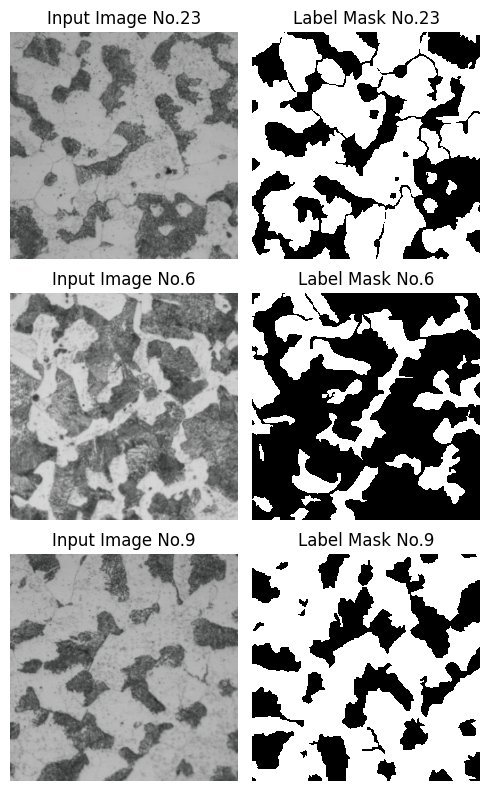

In [4]:
def format_image(img):
    img = np.array(np.transpose(img, (1,2,0)))
    #下は画像拡張での正規化を元に戻しています
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

def visualize_dataset(n_images, num_range, predict=None):
    #TODO:表示時に水平・垂直クリップがかるからかからないようにする(Predictedのほうも)
    images = random.sample(range(0, num_range), n_images)
    figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
    print(images)
    for i in range(0, len(images)):
        img_no = images[i]
        image, mask = train_dataset[i]
        image = format_image(image)
        mask = format_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title(f"Input Image No.{img_no+1}")
        ax[i, 1].set_title(f"Label Mask No.{img_no+1}")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

num_range = len(train_dataset)
visualize_dataset(3, num_range)

In [5]:
split_ratio = 0.25
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=10)

print("Length of train　data: {}".format(len(train_data)))
print("Length of validation　data: {}".format(len(valid_data)))

Length of train　data: 45
Length of validation　data: 15


In [6]:
# UNet
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        # 資料中の『FCN』に当たる部分
        self.conv1 = conv_bn_relu(input_channels,64)
        self.conv2 = conv_bn_relu(64, 128)
        self.conv3 = conv_bn_relu(128, 256)
        self.conv4 = conv_bn_relu(256, 512)
        self.conv5 = conv_bn_relu(512, 1024)
        self.down_pooling = nn.MaxPool2d(2)

        # 資料中の『Up Sampling』に当たる部分
        self.up_pool6 = up_pooling(1024, 512)
        self.conv6 = conv_bn_relu(1024, 512)
        self.up_pool7 = up_pooling(512, 256)
        self.conv7 = conv_bn_relu(512, 256)
        self.up_pool8 = up_pooling(256, 128)
        self.conv8 = conv_bn_relu(256, 128)
        self.up_pool9 = up_pooling(128, 64)
        self.conv9 = conv_bn_relu(128, 64)
        self.conv10 = nn.Conv2d(64, output_channels, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # 正規化
        x = x/255.

        # 資料中の『FCN』に当たる部分
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)

        # 資料中の『Up Sampling』に当たる部分, torch.catによりSkip Connectionをしている
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)

        output = self.conv10(x9)
        output = torch.sigmoid(output)

        return output

#畳み込みとバッチ正規化と活性化関数Reluをまとめている
def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    )

def down_pooling():
    return nn.MaxPool2d(2)

def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        #転置畳み込み
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )



In [7]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice


In [8]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU

In [9]:
#<---------------各インスタンス作成---------------------->
model = UNet(3,1).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = DiceLoss()
accuracy_metric = IoU()

valid_loss_min = np.Inf

best_model_file = '/best_model.pth'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(NUM_EPOCHS):
  #<---------------トレーニング---------------------->
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
      x_train = torch.autograd.Variable(x_train).cuda()
      y_train = torch.autograd.Variable(y_train).cuda()
      optimizer.zero_grad()
      output = model(x_train)
      ## 損失計算
      loss = criterion(output, y_train)
      losses_value = loss.item()
      ## 精度評価
      score = accuracy_metric(output,y_train)
      loss.backward()
      optimizer.step()
      train_loss.append(losses_value)
      train_score.append(score.item())
      pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")
    #<---------------評価---------------------->
    with torch.no_grad():
      for image,mask in val_loader:
        image = torch.autograd.Variable(image).cuda()
        mask = torch.autograd.Variable(mask).cuda()
        output = model(image)
        ## 損失計算
        loss = criterion(output, mask)
        losses_value = loss.item()
        ## 精度評価
        score = accuracy_metric(output,mask)
        valid_loss.append(losses_value)
        valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}")
    print(f"Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}")

    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    ## 容量をとるので必要になったら保存する
    # checkpoint_file = "/checkpoint_{}_weight.pth".format(epoch+1)
    # checkpointの保存
    # torch.save(checkpoint, CHECKPOINT_PATH_UNet + checkpoint_file)
    
    # 評価データにおいて最高精度のモデルのcheckpointの保存
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        torch.save(checkpoint, CHECKPOINT_PATH_UNet + best_model_file)
        valid_loss_min = total_valid_loss[-1]

    print("")
    


Epoch: 1, loss: 0.151943805941677, IoU: 0.7361964107427371: 100%|█| 5/5 [00


Train Loss: 0.24606661586947745, Train IOU: 0.639600909852467
Valid Loss: 0.10450243549688315, Valid IOU: 0.8127083278315554
Validation loss decreased (inf --> 0.104502).  Saving model ...



Epoch: 2, loss: 0.07822753376846103, IoU: 0.854896355827675: 100%|█| 5/5 [0


Train Loss: 0.09708979320080517, Train IOU: 0.8239042794474642
Valid Loss: 0.09695884014793199, Valid IOU: 0.8244399385725966
Validation loss decreased (0.104502 --> 0.096959).  Saving model ...



Epoch: 3, loss: 0.05348798423155787, IoU: 0.8984556586158179: 100%|█| 5/5 [


Train Loss: 0.08929043949406996, Train IOU: 0.8394483894568454
Valid Loss: 0.0949424443244054, Valid IOU: 0.8279643711991467
Validation loss decreased (0.096959 --> 0.094942).  Saving model ...



Epoch: 4, loss: 0.14891919149432942, IoU: 0.7407671965989365: 100%|█| 5/5 [


Train Loss: 0.08520656900378012, Train IOU: 0.8449563028247246
Valid Loss: 0.09886750188955423, Valid IOU: 0.8200590496803719



Epoch: 5, loss: 0.055206801237270064, IoU: 0.8953632881503172: 100%|█| 5/5 


Train Loss: 0.07087172595712662, Train IOU: 0.8679177835311428
Valid Loss: 0.08860711218386136, Valid IOU: 0.8377278207485175
Validation loss decreased (0.094942 --> 0.088607).  Saving model ...



Epoch: 6, loss: 0.11819881273454147, IoU: 0.7885912399984325: 100%|█| 5/5 [


Train Loss: 0.07736309975058202, Train IOU: 0.8573227323463293
Valid Loss: 0.0858982032651665, Valid IOU: 0.8424146979796289
Validation loss decreased (0.088607 --> 0.085898).  Saving model ...



Epoch: 7, loss: 0.07235700767063447, IoU: 0.8650508760748278: 100%|█| 5/5 [


Train Loss: 0.06708827985972525, Train IOU: 0.874469956639925
Valid Loss: 0.0869842488655646, Valid IOU: 0.8401256593747015



Epoch: 8, loss: 0.04808749336712581, IoU: 0.9082378420645573: 100%|█| 5/5 [


Train Loss: 0.06884054710558137, Train IOU: 0.8715274937697128
Valid Loss: 0.0819610212642356, Valid IOU: 0.8486975030833204
Validation loss decreased (0.085898 --> 0.081961).  Saving model ...



Epoch: 9, loss: 0.0516272732530737, IoU: 0.901814745743164: 100%|█| 5/5 [00


Train Loss: 0.06015368131019687, Train IOU: 0.8866988431790004
Valid Loss: 0.08034337306548955, Valid IOU: 0.8515554237055012
Validation loss decreased (0.081961 --> 0.080343).  Saving model ...



Epoch: 10, loss: 0.04576197371188362, IoU: 0.9124812715792985: 100%|█| 5/5 


Train Loss: 0.06630132116793275, Train IOU: 0.8761928572176438
Valid Loss: 0.08053126219647383, Valid IOU: 0.8515551986518926



Epoch: 11, loss: 0.03504988958575539, IoU: 0.9322741448518845: 100%|█| 5/5 


Train Loss: 0.062024825144905794, Train IOU: 0.8842328350396427
Valid Loss: 0.07854764103228701, Valid IOU: 0.8547228785005259
Validation loss decreased (0.080343 --> 0.078548).  Saving model ...



Epoch: 12, loss: 0.06321572276567056, IoU: 0.8810860969613695: 100%|█| 5/5 


Train Loss: 0.05936283014846189, Train IOU: 0.8881236816306822
Valid Loss: 0.07229684324493002, Valid IOU: 0.8656955396258709
Validation loss decreased (0.078548 --> 0.072297).  Saving model ...



Epoch: 13, loss: 0.037435020610038894, IoU: 0.9278317434552008: 100%|█| 5/5


Train Loss: 0.051501022842311464, Train IOU: 0.9023526972639775
Valid Loss: 0.06897794093078374, Valid IOU: 0.8716493436888331
Validation loss decreased (0.072297 --> 0.068978).  Saving model ...



Epoch: 14, loss: 0.05403942280801899, IoU: 0.8974624837927566: 100%|█| 5/5 


Train Loss: 0.05581332983572431, Train IOU: 0.8945182710667906
Valid Loss: 0.09995328770306, Valid IOU: 0.8184377487840351



Epoch: 15, loss: 0.08315562764865037, IoU: 0.8464571574107365: 100%|█| 5/5 


Train Loss: 0.06897390145881, Train IOU: 0.8723273348624959
Valid Loss: 0.07481458977685218, Valid IOU: 0.8614042839903688



Epoch: 16, loss: 0.08430310454466228, IoU: 0.8445030739037127: 100%|█| 5/5 


Train Loss: 0.06391229717788738, Train IOU: 0.8811258275309493
Valid Loss: 0.0780522285100374, Valid IOU: 0.8555088206210423



Epoch: 17, loss: 0.03178079759761321, IoU: 0.9383963340010957: 100%|█| 5/5 


Train Loss: 0.05077266227786796, Train IOU: 0.9036800735760888
Valid Loss: 0.0666801213260711, Valid IOU: 0.8756568505044882
Validation loss decreased (0.068978 --> 0.066680).  Saving model ...



Epoch: 18, loss: 0.03232187616868187, IoU: 0.9373803562763198: 100%|█| 5/5 


Train Loss: 0.050030216838822604, Train IOU: 0.9051100670710495
Valid Loss: 0.0707112025260836, Valid IOU: 0.8683197924112689



Epoch: 19, loss: 0.0386440545821739, IoU: 0.9255877073074846: 100%|█| 5/5 [


Train Loss: 0.05357638779195049, Train IOU: 0.8994183255740105
Valid Loss: 0.08683467485721297, Valid IOU: 0.8403651247603097



Epoch: 20, loss: 0.06158723143854039, IoU: 0.8839717048165238: 100%|█| 5/5 


Train Loss: 0.0539179014851505, Train IOU: 0.8980399545522262
Valid Loss: 0.06830146900535106, Valid IOU: 0.8730199691419338



Epoch: 21, loss: 0.03728067199184515, IoU: 0.9281186322073659: 100%|█| 5/5 


Train Loss: 0.04800437875896211, Train IOU: 0.9084763172741989
Valid Loss: 0.06692488210097691, Valid IOU: 0.8754233837856926



Epoch: 22, loss: 0.040883361840532095, IoU: 0.9214450690515943: 100%|█| 5/5


Train Loss: 0.048330801464399165, Train IOU: 0.908003657815193
Valid Loss: 0.07480367021806739, Valid IOU: 0.8610366954980518



Epoch: 23, loss: 0.03803904321384466, IoU: 0.9267099572422552: 100%|█| 5/5 


Train Loss: 0.046742350740376026, Train IOU: 0.9107542345057767
Valid Loss: 0.06949684919005716, Valid IOU: 0.8704648458953214



Epoch: 24, loss: 0.06550935294021931, IoU: 0.877036854909817: 100%|█| 5/5 [


Train Loss: 0.051228832463561226, Train IOU: 0.902785945625632
Valid Loss: 0.06839868570326696, Valid IOU: 0.872501391721511



Epoch: 25, loss: 0.06598631443963843, IoU: 0.876196924340289: 100%|█| 5/5 [


Train Loss: 0.05590738604806296, Train IOU: 0.8944871187026744
Valid Loss: 0.07852801330796566, Valid IOU: 0.8544427457760561



Epoch: 26, loss: 0.05218227684958643, IoU: 0.9008115895083997: 100%|█| 5/5 


Train Loss: 0.051950039364315394, Train IOU: 0.9013514157823191
Valid Loss: 0.07101712101125335, Valid IOU: 0.867742882066932



Epoch: 27, loss: 0.049090149719411835, IoU: 0.9064141077517602: 100%|█| 5/5


Train Loss: 0.04896481108393824, Train IOU: 0.9069045976154829
Valid Loss: 0.06548592107617102, Valid IOU: 0.8778223579421581
Validation loss decreased (0.066680 --> 0.065486).  Saving model ...



Epoch: 28, loss: 0.1117389218580046, IoU: 0.7989841746217196: 100%|█| 5/5 [


Train Loss: 0.056288475437482145, Train IOU: 0.8947513832973117
Valid Loss: 0.07158071244481451, Valid IOU: 0.8667898348937588



Epoch: 29, loss: 0.03954755029301271, IoU: 0.9239141026482983: 100%|█| 5/5 


Train Loss: 0.05327537327689844, Train IOU: 0.8989858686625283
Valid Loss: 0.07101688613476581, Valid IOU: 0.8686403023579291



Epoch: 30, loss: 0.0729388012270793, IoU: 0.864039511798063: 100%|█| 5/5 [0


Train Loss: 0.057344448166107356, Train IOU: 0.8917763339723225
Valid Loss: 0.07834651186805897, Valid IOU: 0.854882878595998



Epoch: 31, loss: 0.051929223208062036, IoU: 0.9012688352286704: 100%|█| 5/5


Train Loss: 0.05306282084680967, Train IOU: 0.899248078580006
Valid Loss: 0.07580424501501487, Valid IOU: 0.8595108570476582



Epoch: 32, loss: 0.034602018860109385, IoU: 0.9331106185648453: 100%|█| 5/5


Train Loss: 0.055332855804992184, Train IOU: 0.8955784509790083
Valid Loss: 0.07316431141875324, Valid IOU: 0.8641849072434274



Epoch: 33, loss: 0.046360934621245686, IoU: 0.911386565802552: 100%|█| 5/5 


Train Loss: 0.052947334310061336, Train IOU: 0.899483147212336
Valid Loss: 0.07122651992800988, Valid IOU: 0.8674778005279746



Epoch: 34, loss: 0.026002909677505848, IoU: 0.9493123402294869: 100%|█| 5/5


Train Loss: 0.048704904417015096, Train IOU: 0.9074128550790095
Valid Loss: 0.07040813847638383, Valid IOU: 0.8690849140980761



Epoch: 35, loss: 0.051600903573464696, IoU: 0.9018625178797804: 100%|█| 5/5


Train Loss: 0.04745780388344125, Train IOU: 0.9094372310446042
Valid Loss: 0.07182075243954539, Valid IOU: 0.8664189866565386



Epoch: 36, loss: 0.04552146423948178, IoU: 0.9129211419395238: 100%|█| 5/5 


Train Loss: 0.04799884883775314, Train IOU: 0.9084868311940524
Valid Loss: 0.06722295736912715, Valid IOU: 0.8744746151273155



Epoch: 37, loss: 0.07052083059510006, IoU: 0.8682497045654812: 100%|█| 5/5 


Train Loss: 0.06324071655372103, Train IOU: 0.8827571012820217
Valid Loss: 0.06841403831965837, Valid IOU: 0.8727226688246366



Epoch: 38, loss: 0.05631729070888125, IoU: 0.8933707565012601: 100%|█| 5/5 


Train Loss: 0.06341165142618203, Train IOU: 0.8815069669401568
Valid Loss: 0.07107227550496753, Valid IOU: 0.8682969590172855



Epoch: 39, loss: 0.048569369507091786, IoU: 0.9073608873705378: 100%|█| 5/5


Train Loss: 0.0544462400282564, Train IOU: 0.8967663614371334
Valid Loss: 0.07131680605553575, Valid IOU: 0.867678374796161



Epoch: 40, loss: 0.05960024776664807, IoU: 0.8875045883977645: 100%|█| 5/5 


Train Loss: 0.05334657621112069, Train IOU: 0.898895308791927
Valid Loss: 0.07047797446835219, Valid IOU: 0.8691707570177786



Epoch: 41, loss: 0.045883907331105145, IoU: 0.9122582853191892: 100%|█| 5/5


Train Loss: 0.05198297090357553, Train IOU: 0.9012578173483584
Valid Loss: 0.07297526699354301, Valid IOU: 0.864390146251813



Epoch: 42, loss: 0.03827008255145847, IoU: 0.9262812581572324: 100%|█| 5/5 


Train Loss: 0.04788438117112228, Train IOU: 0.9087399835055632
Valid Loss: 0.06866841360373344, Valid IOU: 0.8720270024671675



Epoch: 43, loss: 0.0677872049778585, IoU: 0.8730327011369708: 100%|█| 5/5 [


Train Loss: 0.05057968805982662, Train IOU: 0.9039229483625453
Valid Loss: 0.07051862590197322, Valid IOU: 0.8686109528217218



Epoch: 44, loss: 0.0438935840281941, IoU: 0.9159042763477003: 100%|█| 5/5 [


Train Loss: 0.05327743532963598, Train IOU: 0.8993220617662183
Valid Loss: 0.06850918110083054, Valid IOU: 0.8723837137875572



Epoch: 45, loss: 0.0282800231562369, IoU: 0.9449956044012205: 100%|█| 5/5 [


Train Loss: 0.04898997546152597, Train IOU: 0.9072525789193705
Valid Loss: 0.06650392844813918, Valid IOU: 0.8760705701710885



Epoch: 46, loss: 0.052596202695838645, IoU: 0.9000641812332079: 100%|█| 5/5


Train Loss: 0.04906784965483972, Train IOU: 0.9065790037558747
Valid Loss: 0.06997971811404441, Valid IOU: 0.8695239453414159



Epoch: 47, loss: 0.04964618656052111, IoU: 0.9054041991788104: 100%|█| 5/5 


Train Loss: 0.07056411080104381, Train IOU: 0.8694000675492761
Valid Loss: 0.06636870717576676, Valid IOU: 0.8763789771450798



Epoch: 48, loss: 0.08583733608855881, IoU: 0.841896947410695: 100%|█| 5/5 [


Train Loss: 0.0521268659788892, Train IOU: 0.9014316872913202
Valid Loss: 0.08843516687470643, Valid IOU: 0.8376484234689481



Epoch: 49, loss: 0.04430651624612092, IoU: 0.915146778636475: 100%|█| 5/5 [


Train Loss: 0.04909561659971133, Train IOU: 0.9065139507377744
Valid Loss: 0.06726072401872829, Valid IOU: 0.8746080784153114



Epoch: 50, loss: 0.06638987229538751, IoU: 0.8754870028218585: 100%|█| 5/5 


Train Loss: 0.056869929619026795, Train IOU: 0.8933901058843347
Valid Loss: 0.06591185220697265, Valid IOU: 0.8770721795048997



Epoch: 51, loss: 0.053517428661196575, IoU: 0.898402611601786: 100%|█| 5/5 


Train Loss: 0.0515097310392145, Train IOU: 0.9020930593751032
Valid Loss: 0.07036547958534833, Valid IOU: 0.8687351391221156



Epoch: 52, loss: 0.13166548364446373, IoU: 0.7673074174430763: 100%|█| 5/5 


Train Loss: 0.06023411871079036, Train IOU: 0.8884745359160957
Valid Loss: 0.06714017894997648, Valid IOU: 0.8751265225568816



Epoch: 53, loss: 0.04050439661324434, IoU: 0.9221448627268319: 100%|█| 5/5 


Train Loss: 0.045486302799481536, Train IOU: 0.913145898884759
Valid Loss: 0.06747118598094876, Valid IOU: 0.8741443881116295



Epoch: 54, loss: 0.04501037057812174, IoU: 0.913856820667569: 100%|█| 5/5 [


Train Loss: 0.0459077812862442, Train IOU: 0.9122318277147059
Valid Loss: 0.0688794725009565, Valid IOU: 0.8714861487721584



Epoch: 55, loss: 0.0431596675488537, IoU: 0.9172522487158113: 100%|█| 5/5 [


Train Loss: 0.04490849763221216, Train IOU: 0.9140631438349207
Valid Loss: 0.06542267837619842, Valid IOU: 0.8777467514903944
Validation loss decreased (0.065486 --> 0.065423).  Saving model ...



Epoch: 56, loss: 0.04514096505239207, IoU: 0.9136176832592181: 100%|█| 5/5 


Train Loss: 0.04415982182575051, Train IOU: 0.9155122738720458
Valid Loss: 0.06592324368715924, Valid IOU: 0.877002667326746



Epoch: 57, loss: 0.06144274041573672, IoU: 0.8842282364497805: 100%|█| 5/5 


Train Loss: 0.04932694324161875, Train IOU: 0.9064063374777247
Valid Loss: 0.06512420972871391, Valid IOU: 0.8784039854767046
Validation loss decreased (0.065423 --> 0.065124).  Saving model ...



Epoch: 58, loss: 0.044509472253341786, IoU: 0.9147746234525668: 100%|█| 5/5


Train Loss: 0.044764589745384484, Train IOU: 0.914349368089239
Valid Loss: 0.06543843056811066, Valid IOU: 0.8776920117928159



Epoch: 59, loss: 0.04462729860325765, IoU: 0.9145586475014338: 100%|█| 5/5 


Train Loss: 0.045107495213215706, Train IOU: 0.9137869078582387
Valid Loss: 0.0640250970261152, Valid IOU: 0.8801356345274903
Validation loss decreased (0.065124 --> 0.064025).  Saving model ...



Epoch: 60, loss: 0.040746463992822335, IoU: 0.921697792512206: 100%|█| 5/5 


Train Loss: 0.04192576706911968, Train IOU: 0.9195722164743474
Valid Loss: 0.06413401764349125, Valid IOU: 0.8800778643699396



Epoch: 61, loss: 0.05634724088271248, IoU: 0.8933171316398244: 100%|█| 5/5 


Train Loss: 0.044287334271279864, Train IOU: 0.9152864135234153
Valid Loss: 0.06516078996138447, Valid IOU: 0.8780717117547717



Epoch: 62, loss: 0.0517033062420903, IoU: 0.901677259376004: 100%|█| 5/5 [0


Train Loss: 0.04859146881074301, Train IOU: 0.907631488123584
Valid Loss: 0.06512752263578658, Valid IOU: 0.878319992919201



Epoch: 63, loss: 0.06494171054139164, IoU: 0.878037465542192: 100%|█| 5/5 [


Train Loss: 0.045844209502810054, Train IOU: 0.9126108215484973
Valid Loss: 0.06337407309203325, Valid IOU: 0.8815353103212946
Validation loss decreased (0.064025 --> 0.063374).  Saving model ...



Epoch: 64, loss: 0.04975557450477075, IoU: 0.9052056127423785: 100%|█| 5/5 


Train Loss: 0.0431888244421651, Train IOU: 0.9172849063739589
Valid Loss: 0.0620832208561688, Valid IOU: 0.8838180293453175
Validation loss decreased (0.063374 --> 0.062083).  Saving model ...



Epoch: 65, loss: 0.0383292470966512, IoU: 0.9261714556886466: 100%|█| 5/5 [


Train Loss: 0.042512215876654325, Train IOU: 0.9185151333075442
Valid Loss: 0.06177980565511915, Valid IOU: 0.8843758770694836
Validation loss decreased (0.062083 --> 0.061780).  Saving model ...



Epoch: 66, loss: 0.05055902322737338, IoU: 0.9037485602778204: 100%|█| 5/5 


Train Loss: 0.04315803294366956, Train IOU: 0.917354364595403
Valid Loss: 0.059739016791052535, Valid IOU: 0.8878844450824861
Validation loss decreased (0.061780 --> 0.059739).  Saving model ...



Epoch: 67, loss: 0.09742556538826574, IoU: 0.8224476496977541: 100%|█| 5/5 


Train Loss: 0.05312893838665034, Train IOU: 0.8999598348011839
Valid Loss: 0.06114471807465893, Valid IOU: 0.885461842404381



Epoch: 68, loss: 0.05959894550044342, IoU: 0.887506883186263: 100%|█| 5/5 [


Train Loss: 0.04570825787655104, Train IOU: 0.9127964044382375
Valid Loss: 0.06686718668892427, Valid IOU: 0.8751491979317931



Epoch: 69, loss: 0.06033564559346527, IoU: 0.8861955674064727: 100%|█| 5/5 


Train Loss: 0.04503363611802116, Train IOU: 0.9140751643315893
Valid Loss: 0.06265692470838385, Valid IOU: 0.8825238444531206



Epoch: 70, loss: 0.06412353047669295, IoU: 0.8794813868383157: 100%|█| 5/5 


Train Loss: 0.0444598852314799, Train IOU: 0.9150858876129042
Valid Loss: 0.06242000491521965, Valid IOU: 0.8830453902862796



Epoch: 71, loss: 0.03543539702754528, IoU: 0.931554703416929: 100%|█| 5/5 [


Train Loss: 0.04250535484534523, Train IOU: 0.9186466638740196
Valid Loss: 0.06111369456247584, Valid IOU: 0.8853208533524072



Epoch: 72, loss: 0.04502000106265669, IoU: 0.9138392242556359: 100%|█| 5/5 


Train Loss: 0.041486044610627215, Train IOU: 0.9203697560746642
Valid Loss: 0.06305315308143489, Valid IOU: 0.8816446812290595



Epoch: 73, loss: 0.03943562876161688, IoU: 0.9241212406770157: 100%|█| 5/5 


Train Loss: 0.04121708247813942, Train IOU: 0.9208846264423693
Valid Loss: 0.05975388011383187, Valid IOU: 0.8877354130481137



Epoch: 74, loss: 0.050317134397613206, IoU: 0.9041870203076968: 100%|█| 5/5


Train Loss: 0.041639396604571256, Train IOU: 0.9201485284203621
Valid Loss: 0.060486444516694604, Valid IOU: 0.8865840233329976



Epoch: 75, loss: 0.04482508048657019, IoU: 0.9141961751447311: 100%|█| 5/5 


Train Loss: 0.041776072797956185, Train IOU: 0.9198620439422767
Valid Loss: 0.060453508027273006, Valid IOU: 0.8865576577712375



Epoch: 76, loss: 0.04729649786721479, IoU: 0.9096791480326959: 100%|█| 5/5 


Train Loss: 0.040244884441018904, Train IOU: 0.9226902562352451
Valid Loss: 0.05885942696951263, Valid IOU: 0.8893827547949693
Validation loss decreased (0.059739 --> 0.058859).  Saving model ...



Epoch: 77, loss: 0.046134799246411395, IoU: 0.9117998123923541: 100%|█| 5/5


Train Loss: 0.04317960405845456, Train IOU: 0.9173521439681614
Valid Loss: 0.05821953920696121, Valid IOU: 0.8905323533553624
Validation loss decreased (0.058859 --> 0.058220).  Saving model ...



Epoch: 78, loss: 0.029097254455485055, IoU: 0.9434510211567287: 100%|█| 5/5


Train Loss: 0.03963999107750362, Train IOU: 0.923877339995447
Valid Loss: 0.06030345652474112, Valid IOU: 0.8868238835627817



Epoch: 79, loss: 0.0484396385615693, IoU: 0.907596962634557: 100%|█| 5/5 [0


Train Loss: 0.040956022541291624, Train IOU: 0.9214151974079977
Valid Loss: 0.058646077319345624, Valid IOU: 0.8897689661955508



Epoch: 80, loss: 0.044085382141665574, IoU: 0.9155523662579403: 100%|█| 5/5


Train Loss: 0.041006623429252965, Train IOU: 0.9212848152672528
Valid Loss: 0.058940539040837736, Valid IOU: 0.8893857091924297



Epoch: 81, loss: 0.048879544148197285, IoU: 0.9067969305066316: 100%|█| 5/5


Train Loss: 0.039562473828369436, Train IOU: 0.9239357983053592
Valid Loss: 0.05872720748030724, Valid IOU: 0.8896653239470854



Epoch: 82, loss: 0.03707637425785204, IoU: 0.9284984915218506: 100%|█| 5/5 


Train Loss: 0.03821945954695456, Train IOU: 0.9264047304209807
Valid Loss: 0.059228007922576764, Valid IOU: 0.8886971976691995



Epoch: 83, loss: 0.03302332558025278, IoU: 0.93606488222207: 100%|█| 5/5 [0


Train Loss: 0.037475168348520806, Train IOU: 0.9277757999062466
Valid Loss: 0.059587831509003486, Valid IOU: 0.8880910516519613



Epoch: 84, loss: 0.07057324305838752, IoU: 0.8681585222638298: 100%|█| 5/5 


Train Loss: 0.043470296238621045, Train IOU: 0.9170344897001147
Valid Loss: 0.05950088570222689, Valid IOU: 0.8882951533011951



Epoch: 85, loss: 0.04399198847477359, IoU: 0.9157237132612311: 100%|█| 5/5 


Train Loss: 0.0392220338667177, Train IOU: 0.924632670258838
Valid Loss: 0.05982061684623918, Valid IOU: 0.8877479515473023



Epoch: 86, loss: 0.04747589766310756, IoU: 0.9093519980753229: 100%|█| 5/5 


Train Loss: 0.03914561093112454, Train IOU: 0.9247058762193678
Valid Loss: 0.05719669565089097, Valid IOU: 0.8923851985430533
Validation loss decreased (0.058220 --> 0.057197).  Saving model ...



Epoch: 87, loss: 0.0706745356453996, IoU: 0.867981530113418: 100%|█| 5/5 [0


Train Loss: 0.04752441806001388, Train IOU: 0.9096725791761411
Valid Loss: 0.05895286918393161, Valid IOU: 0.8894149761296487



Epoch: 88, loss: 0.047982603249810296, IoU: 0.9084288828119229: 100%|█| 5/5


Train Loss: 0.046436212262214414, Train IOU: 0.9114398859986199
Valid Loss: 0.06548540481484749, Valid IOU: 0.877558581084795



Epoch: 89, loss: 0.03516401593620189, IoU: 0.9320611152412793: 100%|█| 5/5 


Train Loss: 0.04290637415108223, Train IOU: 0.9178565123128178
Valid Loss: 0.06651155168758904, Valid IOU: 0.8757424862277847



Epoch: 90, loss: 0.034134224547190284, IoU: 0.9339850967275125: 100%|█| 5/5


Train Loss: 0.04153119855743006, Train IOU: 0.9203283995030901
Valid Loss: 0.0604031011424343, Valid IOU: 0.8865310982108634



Epoch: 91, loss: 0.03806140959229709, IoU: 0.9266684446198046: 100%|█| 5/5 


Train Loss: 0.0419317028538986, Train IOU: 0.9196698505035359
Valid Loss: 0.0617436685211219, Valid IOU: 0.8841948590170111



Epoch: 92, loss: 0.0559935009044773, IoU: 0.8939513936767833: 100%|█| 5/5 [


Train Loss: 0.04304368836646259, Train IOU: 0.9175926884010102
Valid Loss: 0.0596137741753362, Valid IOU: 0.8879512792370617



Epoch: 93, loss: 0.039041913888095525, IoU: 0.9248503500440759: 100%|█| 5/5


Train Loss: 0.039205866080527854, Train IOU: 0.9245851079218065
Valid Loss: 0.05827529741194204, Valid IOU: 0.8902346708051758



Epoch: 94, loss: 0.026303341706812144, IoU: 0.9487416918500945: 100%|█| 5/5


Train Loss: 0.03741782466773862, Train IOU: 0.9279698686301995
Valid Loss: 0.057884412465134816, Valid IOU: 0.8911471718386001



Epoch: 95, loss: 0.027803779698813758, IoU: 0.9458968192324154: 100%|█| 5/5


Train Loss: 0.03685713034319928, Train IOU: 0.9289657159578457
Valid Loss: 0.05728567772367704, Valid IOU: 0.892179964021407



Epoch: 96, loss: 0.025487492831928193, IoU: 0.9502920306999503: 100%|█| 5/5


Train Loss: 0.036639981750667586, Train IOU: 0.9294084662836151
Valid Loss: 0.05769441354337801, Valid IOU: 0.8915505688456602



Epoch: 97, loss: 0.04858665623024694, IoU: 0.907329490336563: 100%|█| 5/5 [


Train Loss: 0.039645966703884095, Train IOU: 0.9238002634587235
Valid Loss: 0.05725773737672618, Valid IOU: 0.8922357081865152



Epoch: 98, loss: 0.027563350700586686, IoU: 0.9463521786536585: 100%|█| 5/5


Train Loss: 0.036563638948389654, Train IOU: 0.9294945957261694
Valid Loss: 0.05904191020506111, Valid IOU: 0.8889177261753151



Epoch: 99, loss: 0.05027953290667786, IoU: 0.9042551253842455: 100%|█| 5/5 


Train Loss: 0.04095318338015981, Train IOU: 0.9213854306779655
Valid Loss: 0.059896310219575755, Valid IOU: 0.8876943998909201



Epoch: 100, loss: 0.04660668988812333, IoU: 0.9109377934931981: 100%|█| 5/5


Train Loss: 0.04107953689709689, Train IOU: 0.9212004265946865
Valid Loss: 0.0588499080892278, Valid IOU: 0.8896309423231619



<Figure size 640x480 with 0 Axes>

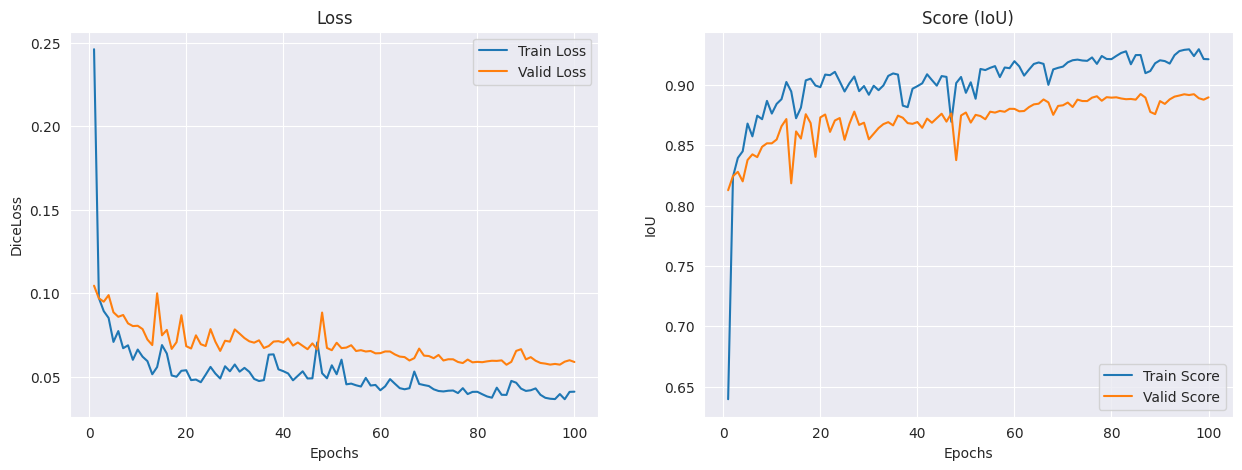

In [10]:
import seaborn as sns

plt.figure(1)
plt.figure(figsize=(15,5))
sns.set_style(style="darkgrid")
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_valid_loss, label="Valid Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("DiceLoss")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_train_score, label="Train Score")
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_valid_score, label="Valid Score")
plt.title("Score (IoU)")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.show()

In [11]:
# bestmodelの読み込み
checkpoint = torch.load(CHECKPOINT_PATH_UNet + best_model_file)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']
valid_loss_min = checkpoint['valid_loss_min']

[11, 18, 47, 50, 5, 34]


/tmp/ipykernel_2009/2669564127.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = torch.autograd.Variable(data, volatile=True).cuda()
/tmp/ipykernel_2009/2669564127.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  mask = torch.autograd.Variable(mask, volatile=True).cuda()


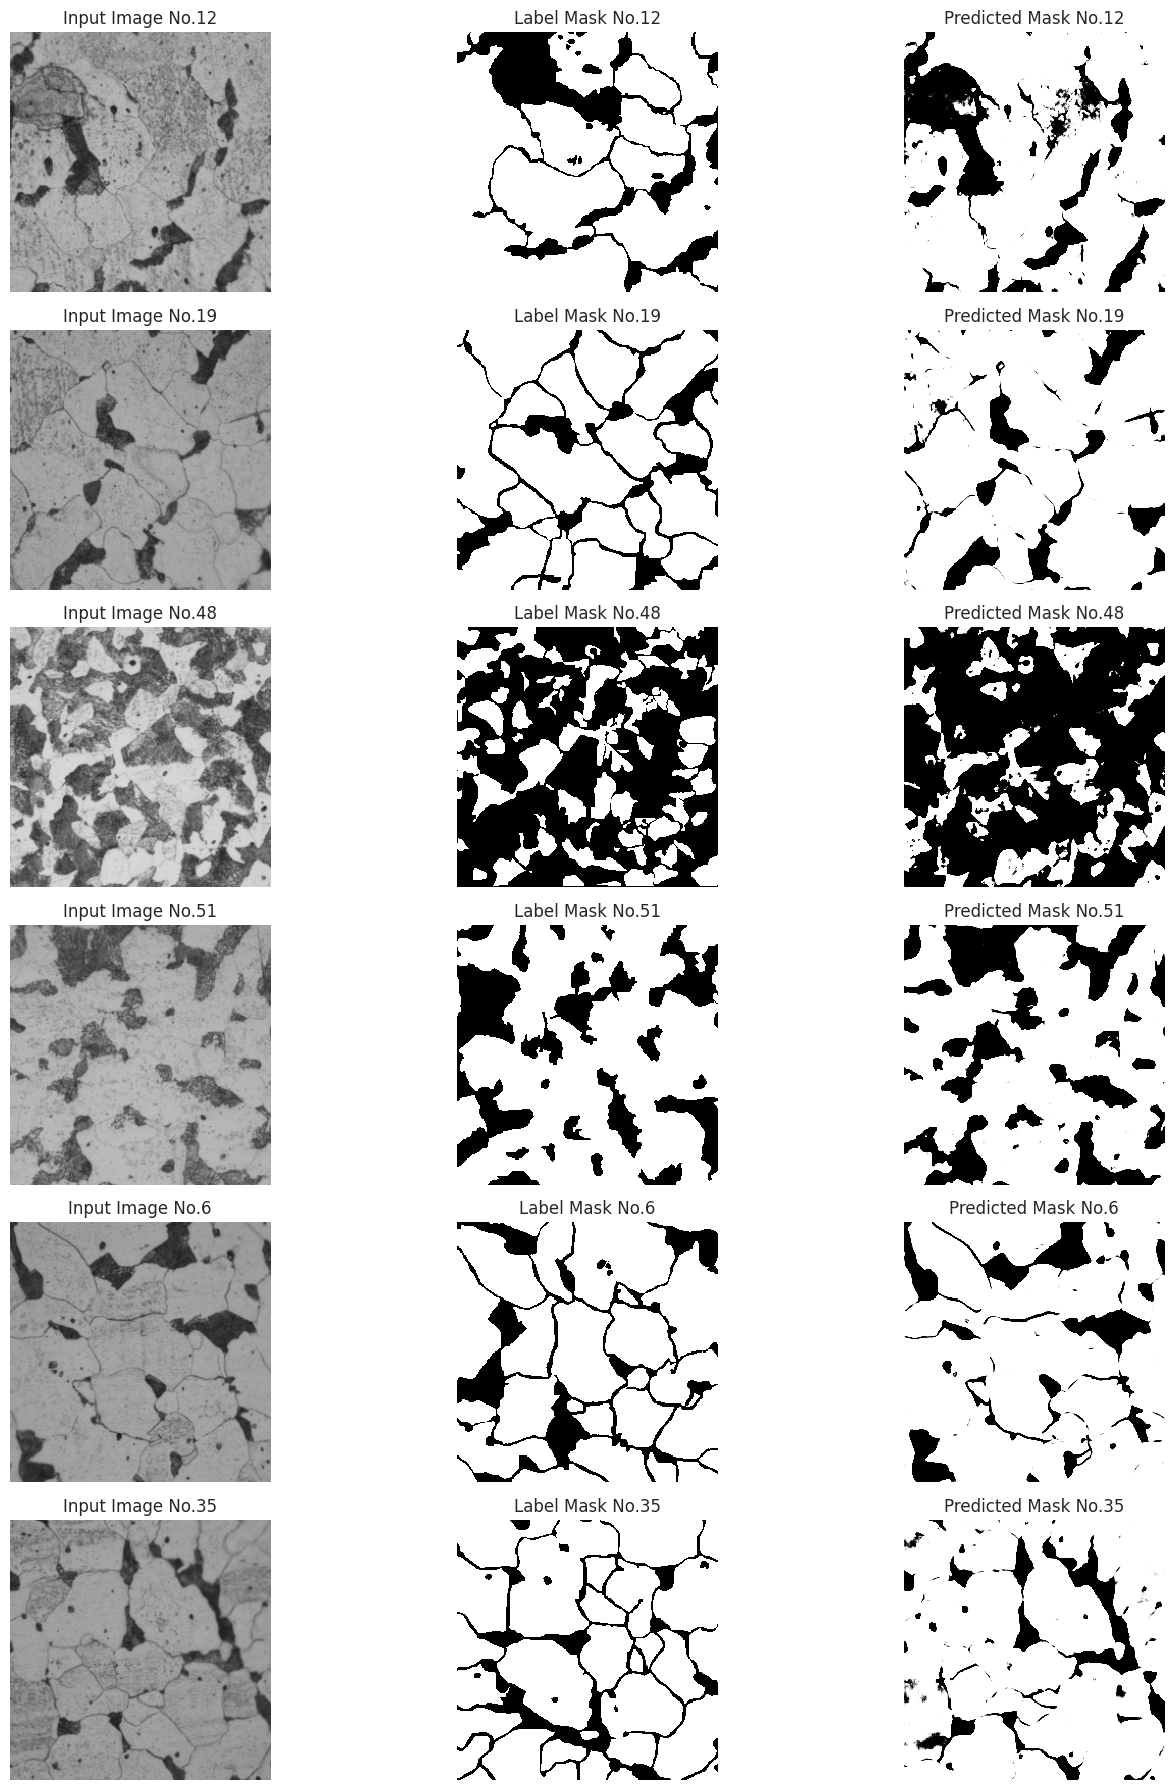

In [12]:
def visualize_predict(model, n_images, num_range):
    images = random.sample(range(0, num_range), n_images)
    print(images)
    # figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
    figure, ax = plt.subplots(nrows=len(images), ncols=3, figsize=(15, 18))
    
    with torch.no_grad():
        for data,mask in val_loader:
            data = torch.autograd.Variable(data, volatile=True).cuda()
            mask = torch.autograd.Variable(mask, volatile=True).cuda()
            o = model(data)
            break
    for i in range(0, len(images)):
        img_no = images[i]
        tm=o[i][0].data.cpu().numpy()
        img = data[i].data.cpu()
        msk = mask[i].data.cpu()
        img = format_image(img)
        msk = format_mask(msk)
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(msk, interpolation="nearest", cmap="gray")
        ax[i, 2].imshow(tm, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title(f"Input Image No.{img_no+1}")
        ax[i, 1].set_title(f"Label Mask No.{img_no+1}")
        ax[i, 2].set_title(f"Predicted Mask No.{img_no+1}")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_predict(model, 6, num_range)